# ScaLoc End-to-End Pipeline Notebook

This notebook walks through the full pipeline **sequentially** using existing project modules:
1. Raw data exploration
2. Data processing pipeline
3. Domain/graph inspection and visualization
4. Training
5. Evaluation and result inspection

> Best practice: run cells top-to-bottom. Heavy steps (training/baselines) are opt-in.

In [1]:
from pathlib import Path
import json
import subprocess
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

from IPython.display import display, Image

ROOT = Path('.').resolve()
print(f'Project root: {ROOT}')

def run_cmd(cmd, label=None):
    if label:
        print(f'\n=== {label} ===')
    print(' '.join(str(c) for c in cmd))
    result = subprocess.run(cmd, cwd=ROOT)
    if result.returncode != 0:
        raise RuntimeError(f'Command failed with exit code {result.returncode}: {cmd}')

def show_files(glob_pattern, max_items=10):
    files = sorted(ROOT.glob(glob_pattern))
    print(f'{glob_pattern}: {len(files)} files')
    for p in files[:max_items]:
        print(' -', p.relative_to(ROOT))
    if len(files) > max_items:
        print(f' ... ({len(files) - max_items} more)')
    return files

Project root: C:\Users\etiab\GitHub\scaloc


## 1) Raw Data Exploration

Train shape: (19937, 529)
Val shape: (1111, 529)


,WAP001,WAP002,WAP003,WAP004,WAP005,WAP006,WAP007,WAP008,WAP009,WAP010,...,WAP520,LONGITUDE,LATITUDE,FLOOR,BUILDINGID,SPACEID,RELATIVEPOSITION,USERID,PHONEID,TIMESTAMP
0,100,100,100,100,100,100,100,100,100,100,...,100,-7541.2643,4.864921e+06,2,1,106,2,2,23,1371713733
1,100,100,100,100,100,100,100,100,100,100,...,100,-7536.6212,4.864934e+06,2,1,106,2,2,23,1371713691
2,100,100,100,100,100,100,100,-97,100,100,...,100,-7519.1524,4.864950e+06,2,1,103,2,2,23,1371714095


,count,mean,std,min,25%,50%,75%,max
BUILDINGID,19937.0,1.212820e+00,0.833139,0.000000e+00,0.000000e+00,1.000000e+00,2.000000e+00,2.000000e+00
FLOOR,19937.0,1.674575e+00,1.223078,0.000000e+00,1.000000e+00,2.000000e+00,3.000000e+00,4.000000e+00
SPACEID,19937.0,1.484300e+02,58.342106,1.000000e+00,1.100000e+02,1.290000e+02,2.070000e+02,2.540000e+02
LONGITUDE,19937.0,-7.464276e+03,123.402010,-7.691338e+03,-7.594737e+03,-7.423061e+03,-7.359193e+03,-7.300819e+03
LATITUDE,19937.0,4.864871e+06,66.933183,4.864746e+06,4.864821e+06,4.864852e+06,4.864930e+06,4.865017e+06


FLOOR,0,1,2,3,4
BUILDINGID,,,,,
0,1059,1356,1443,1391,0
1,1368,1484,1396,948,0
2,1942,2162,1577,2709,1102


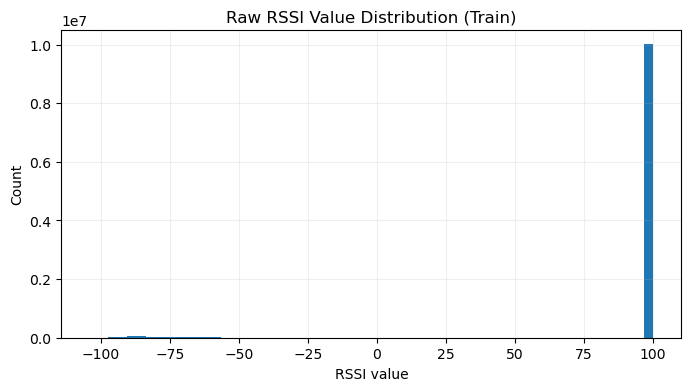

In [ ]:
from src.data.load_raw import load_training_data, load_validation_data

train_df = load_training_data()
val_df = load_validation_data()

print('Train shape:', train_df.shape)
print('Val shape:', val_df.shape)
display(train_df.head(3))

meta_cols = ['BUILDINGID', 'FLOOR', 'SPACEID', 'LONGITUDE', 'LATITUDE']
available_meta = [c for c in meta_cols if c in train_df.columns]
if available_meta:
    summary = train_df[available_meta].describe(include='all').T
    display(summary)

if {'BUILDINGID', 'FLOOR'}.issubset(train_df.columns):
    cnt = train_df.groupby(['BUILDINGID', 'FLOOR']).size().unstack(fill_value=0)
    display(cnt)

wap_cols = [c for c in train_df.columns if c.startswith('WAP')]
if wap_cols:
    # Extract RSSI values, excluding sentinel value 100 (missing)
    sample_vals = train_df[wap_cols].to_numpy().ravel()
    sample_vals = sample_vals[(sample_vals != 100) & np.isfinite(sample_vals)]
    
    plt.figure(figsize=(8, 4))
    plt.hist(sample_vals, bins=60, edgecolor='black', linewidth=0.5)
    plt.title('RSSI Value Distribution (Train, excluding missing=100)')
    plt.xlabel('RSSI (dBm)')
    plt.ylabel('Count')
    plt.grid(alpha=0.2)
    plt.show()
    
    print(f'Valid RSSI range: [{sample_vals.min():.1f}, {sample_vals.max():.1f}]')
    print(f'Mean: {sample_vals.mean():.1f}, Median: {np.median(sample_vals):.1f}')

## 2) Run Data Processing Pipeline
This executes the same ordered modules as `scripts/run_data_pipeline.py`.

In [3]:
DATA_STEPS = [
    ('Step 0: Inspect raw data', [sys.executable, '-m', 'src.data.load_raw']),
    ('Step 1: Clean + preprocess', [sys.executable, '-m', 'src.data.clean_preprocess']),
    ('Step 2: Build domains', [sys.executable, '-m', 'src.data.build_domains']),
    ('Step 3: Build RPs', [sys.executable, '-m', 'src.data.build_rps']),
    ('Step 4: Build graphs', [sys.executable, '-m', 'src.data.build_graphs']),
    ('Step 5: Build samples', [sys.executable, '-m', 'src.data.build_samples']),
]

for label, cmd in DATA_STEPS:
    run_cmd(cmd, label=label)

print('\nData pipeline completed.')


=== Step 0: Inspect raw data ===
c:\Users\etiab\miniconda3\envs\loc\python.exe -m src.data.load_raw

=== Step 1: Clean + preprocess ===
c:\Users\etiab\miniconda3\envs\loc\python.exe -m src.data.clean_preprocess

=== Step 2: Build domains ===
c:\Users\etiab\miniconda3\envs\loc\python.exe -m src.data.build_domains

=== Step 3: Build RPs ===
c:\Users\etiab\miniconda3\envs\loc\python.exe -m src.data.build_rps

=== Step 4: Build graphs ===
c:\Users\etiab\miniconda3\envs\loc\python.exe -m src.data.build_graphs

=== Step 5: Build samples ===
c:\Users\etiab\miniconda3\envs\loc\python.exe -m src.data.build_samples

Data pipeline completed.


## 3) Inspect Processed Artifacts

In [4]:
show_files('data/interim/clean/*.parquet')
show_files('data/interim/domains/*.parquet')
show_files('data/processed/rps/*.parquet')
show_files('data/processed/graphs/*.json')
show_files('data/processed/samples/*.parquet')

train_samples_path = ROOT / 'data/processed/samples/train_samples.parquet'
if train_samples_path.exists():
    train_samples = pd.read_parquet(train_samples_path)
    print('Train samples shape:', train_samples.shape)
    display(train_samples.head(3))

data/interim/clean/*.parquet: 2 files
 - data\interim\clean\train_clean.parquet
 - data\interim\clean\val_clean.parquet
data/interim/domains/*.parquet: 26 files
 - data\interim\domains\train_domain_0_0.parquet
 - data\interim\domains\train_domain_0_1.parquet
 - data\interim\domains\train_domain_0_2.parquet
 - data\interim\domains\train_domain_0_3.parquet
 - data\interim\domains\train_domain_1_0.parquet
 - data\interim\domains\train_domain_1_1.parquet
 - data\interim\domains\train_domain_1_2.parquet
 - data\interim\domains\train_domain_1_3.parquet
 - data\interim\domains\train_domain_2_0.parquet
 - data\interim\domains\train_domain_2_1.parquet
 ... (16 more)
data/processed/rps/*.parquet: 13 files
 - data\processed\rps\train_rps_0_0.parquet
 - data\processed\rps\train_rps_0_1.parquet
 - data\processed\rps\train_rps_0_2.parquet
 - data\processed\rps\train_rps_0_3.parquet
 - data\processed\rps\train_rps_1_0.parquet
 - data\processed\rps\train_rps_1_1.parquet
 - data\processed\rps\train_rps

,domain_id,x,y,aps
0,1_2,-54.682516,42.23175,"[{'ap_id': 'WAP090', 'rssi': -67.0}, {'ap_id':..."
1,1_2,-50.039416,55.67875,"[{'ap_id': 'WAP090', 'rssi': -46.0}, {'ap_id':..."
2,1_2,-32.570616,70.98575,"[{'ap_id': 'WAP008', 'rssi': -97.0}, {'ap_id':..."


## 4) Domain Graph Visualization
Visualize one processed domain graph from `data/processed/graphs`.

Visualizing: data\processed\graphs\train_graph_0_0.json


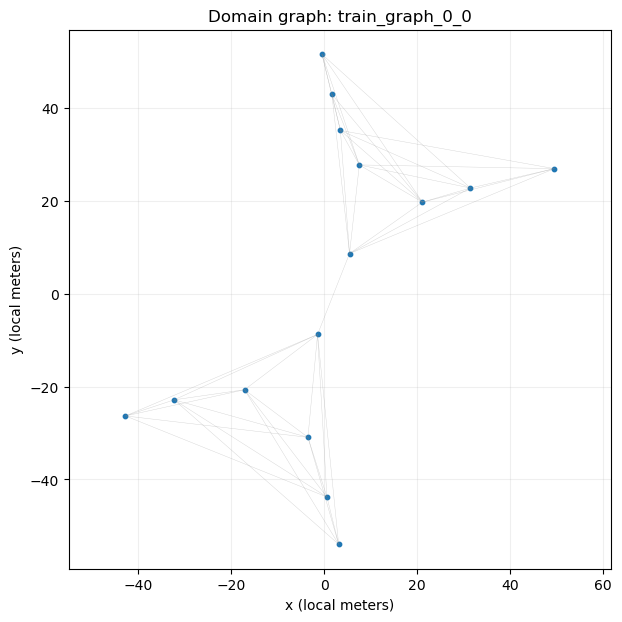

In [5]:
graph_files = sorted((ROOT / 'data/processed/graphs').glob('train_graph_*.json'))
if not graph_files:
    raise FileNotFoundError('No graph JSON files found. Run data pipeline first.')

graph_path = graph_files[0]
print('Visualizing:', graph_path.relative_to(ROOT))

with open(graph_path, 'r') as f:
    graph = json.load(f)

coords = np.asarray(graph['coords'], dtype=float)
edges = graph['edges']

G = nx.Graph()
for node_id in range(len(coords)):
    G.add_node(node_id, pos=(coords[node_id, 0], coords[node_id, 1]))
for u, v, _ in edges:
    G.add_edge(int(u), int(v))

plt.figure(figsize=(7, 7))
for u, v in G.edges():
    x1, y1 = G.nodes[u]['pos']
    x2, y2 = G.nodes[v]['pos']
    plt.plot([x1, x2], [y1, y2], linewidth=0.3, alpha=0.35, color='gray')

plt.scatter(coords[:, 0], coords[:, 1], s=10)
plt.title(f'Domain graph: {graph_path.stem}')
plt.xlabel('x (local meters)')
plt.ylabel('y (local meters)')
plt.axis('equal')
plt.grid(alpha=0.2)
plt.show()

## 5) Training and Evaluation
Use existing scripts for reproducibility. Toggle heavy steps below before execution.

In [6]:
RUN_FEDGNN_TRAINING = False
RUN_BASELINES = False
RUN_PLOTS = False

print('RUN_FEDGNN_TRAINING =', RUN_FEDGNN_TRAINING)
print('RUN_BASELINES =', RUN_BASELINES)
print('RUN_PLOTS =', RUN_PLOTS)

RUN_FEDGNN_TRAINING = False
RUN_BASELINES = False
RUN_PLOTS = False


In [7]:
if RUN_FEDGNN_TRAINING:
    run_cmd([sys.executable, 'run_fl_experiment.py'], label='Federated GNN training')
else:
    print('Skipped FedGNN training (set RUN_FEDGNN_TRAINING=True to run).')

if RUN_BASELINES:
    run_cmd([sys.executable, 'scripts/run_baselines.py'], label='Run baselines')
else:
    print('Skipped baselines (set RUN_BASELINES=True to run).')

if RUN_PLOTS:
    run_cmd([sys.executable, 'scripts/plot_results.py', '--plots', 'all'], label='Generate plots')
else:
    print('Skipped plots (set RUN_PLOTS=True to run).')

Skipped FedGNN training (set RUN_FEDGNN_TRAINING=True to run).
Skipped baselines (set RUN_BASELINES=True to run).
Skipped plots (set RUN_PLOTS=True to run).


## 6) Review Metrics and Plots

In [8]:
fedgnn_path = ROOT / 'results/fedgnn.json'
if fedgnn_path.exists():
    with open(fedgnn_path, 'r') as f:
        fedgnn = json.load(f)

    rounds = fedgnn.get('rounds', [])
    print('FedGNN rounds logged:', len(rounds))
    if rounds:
        final_metrics = rounds[-1].get('eval_metrics', {})
        print('Final FedGNN eval metrics:')
        display(pd.DataFrame([final_metrics]))
else:
    print('No results/fedgnn.json found yet.')

baseline_path = ROOT / 'results/baseline_comparison.json'
if baseline_path.exists():
    with open(baseline_path, 'r') as f:
        base = json.load(f)
    comp = base.get('comparison', base)
    if isinstance(comp, dict) and comp:
        display(pd.DataFrame(comp).T)
else:
    print('No results/baseline_comparison.json found yet.')

plot_files = sorted((ROOT / 'results/plots').glob('*.png'))
if plot_files:
    print(f'Found {len(plot_files)} plot(s). Showing up to 4:')
    for p in plot_files[:4]:
        print(' -', p.relative_to(ROOT))
        display(Image(filename=str(p)))
else:
    print('No plots found in results/plots.')

FedGNN rounds logged: 7
Final FedGNN eval metrics:


""
0


No results/baseline_comparison.json found yet.
No plots found in results/plots.


## Notes
- If imports fail, install dependencies from `requirements.txt`.
- For reproducibility, prefer project scripts/modules over rewriting logic in notebook cells.
- You can replace the selected graph in Section 4 to inspect other domains.